In [172]:
import torch
import os
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from copy import deepcopy
from time import time
import numpy as np
from PIL import Image
from torchvision import models
from tqdm import tqdm
from torch.utils.data.dataset import Dataset

# just to ignore the matplotlib warnings to make the plots look better
import warnings
warnings.filterwarnings('ignore')
# test whether the cuda is available
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(torch.__version__)
print(torch.cuda.is_available())

1.12.1
True


In [173]:
def plot_graph(train_precision, train_recall, train_loss, val_precision, val_recall, val_loss):
    x=range(1,len(train_precision)+1)
    plt.xlabel("iteration")
    plt.plot(x,train_precision,label="train_precision")
    plt.plot(x,train_recall,label="train_recall")
    plt.plot(x,val_precision,label="val_precision")
    plt.plot(x,val_recall,label="val_recall")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    plt.show()

    x=range(1,len(train_loss)+1)
    plt.xlabel("iteration")
    plt.plot(x,train_loss,label="train_loss")
    plt.plot(x,val_loss,label="val_loss")
    plt.legend(loc="lower left")
    plt.show()

In [174]:
import pandas as pd
train_biz=pd.read_csv('./train_photo_to_biz_ids.csv')
test_biz=pd.read_csv('./test_photo_to_biz.csv')
train=pd.read_csv('./train.csv')
sub=pd.read_csv('./sample_submission.csv')

In [175]:
# merging
data=pd.merge(train_biz,train, on='business_id',how='left')
# drop data that missing labels
data=data.dropna(subset=['labels'])

# for competition only
data_task=pd.merge(test_biz,sub, on='business_id',how='left') 

In [176]:
# convert string to list of int
labels=data['labels'].tolist()
for index,x in enumerate(labels):
     labels[index]= [int(c) for c in str(x).split(' ')]
data['labels'] = labels

In [177]:
# use small data set for development
development_size=0.005
unsued_data,data = train_test_split(data,test_size=development_size, random_state=40)

train_data, test_data = train_test_split(data, test_size=0.1, random_state=40)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=40)


In [178]:
# Define dataset class


class Image_Dataset(Dataset):
    def __init__(self, data_path, data, transform=None):
        self.image_id = data['photo_id'].tolist()
        self.labels=data['labels'].tolist()
        self.transform = transform
        self.data_path = data_path
        self.classes = [0,1,2,3,4,5,6,7,8]
        
          
        for index in range(len(self.labels)):
            labels = self.labels[index]
            vector=[0,0,0,0,0,0,0,0,0]
            for i in range(9):
                if i in labels:
                    vector[i] = 1
            self.labels[index] = np.array(vector, dtype=float)

    def __getitem__(self, index):
        label = self.labels[index]
        img_path = os.path.join(self.data_path, str(self.image_id[index])+'.jpg')
        img = Image.open(img_path)
        if self.transform:
            # dont know why all output of the transform are negative
            img = -self.transform(img)
        return img, label
    def __len__(self):
        return len(self.image_id)



In [179]:
# transformation

mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]

train_transform = transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        ])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [180]:
train_dataset = Image_Dataset('./train_photos', train_data, train_transform)
val_dataset = Image_Dataset('./train_photos', val_data, val_transform)
test_dataset = Image_Dataset('./train_photos', test_data, val_transform)

In [181]:
# this part can be tuned
class Resnext50(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=9)
        )
        self.model = resnet
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.model(x))

In [189]:
# this part can be tuned

device = torch.device('cuda')
model = Resnext50()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_func = nn.BCELoss()



# lr = 1e-4 




batch_size= 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True,drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [190]:
epoch = 4

def train(model, optimizer,  device):
    train_precision = []
    train_recall=[]
    train_loss = []
    
    val_precision = []
    val_recall=[]
    val_loss = []
    
    best_f1 = 0
    best_model = None
    best_i = 0
    record_freq = int(math.ceil(len(train_dataloader)/3))
    
    model = model.to(device)
    
    for i in range(epoch):
        model.train()
        
        batch_precision=0
        batch_recall=0
        batch_loss =0
        num = 0
        for images, labels in tqdm(train_dataloader):
            num+=1
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output, labels.type(torch.float))
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                pred = (output>0.5).cpu()
                labels = labels.cpu()
                batch_precision+=precision_score(labels, pred,average='micro')
                batch_recall+=recall_score(labels, pred,average='micro')
                batch_loss+=loss.cpu().detach()
                if num%record_freq==0:
                    train_precision.append(batch_precision/record_freq)
                    train_recall.append(batch_recall/record_freq)
                    train_loss.append(batch_loss/record_freq)
                    batch_precision=0
                    batch_recall=0
                    batch_loss=0
                    
                    # validation
                    model.eval()
                    for images, labels in val_dataloader:
                        images, labels = images.to(device), labels.to(device)
                        output = model(images)
                        
                        loss = loss_func(output, labels.type(torch.float))
                        l2_lambda = 0.001
                        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                        loss = loss + l2_lambda * l2_norm
                        
                        pred = np.array(np.array(output.cpu()) >0.5, dtype=float)
                        labels = labels.cpu()
                        
                        val_precision.append(precision_score(labels,pred,average='micro'))
                        val_recall.append(recall_score(labels,pred,average='micro'))
                        val_loss.append(loss.cpu().detach())
                        
                        f1 = f1_score(labels,pred,average='micro')
                        print('val_precision:{:.4f}, val_recall:{:.4f}, val_loss:{:.4f}, f1:{:.4f}'.format(i, val_precision[-1],val_recall[-1],val_loss[-1],f1))
        
                        if  f1> best_f1:
                            best_f1 = f1
                            best_model = deepcopy(model.state_dict())
                            best_i = i  
        

        print("train_precision:{:.4f}, train_recall:{:.4f}, train_loss:{:.4f}".format(train_precision[-1],train_recall[-1],train_loss[-1]))
        
        print('val_precision:{:.4f}, val_recall:{:.4f}, val_loss:{:.4f}, f1:{:.4f}'.format(i, val_precision[-1],val_recall[-1],val_loss[-1],f1))

    print('best epoch {}, train precision {:.4f} val precision {:.4f}, f1 {:.4f}'.format(best_i, train_precision[best_i], val_precision[best_i], best_f1))
    model.load_state_dict(best_model)
    return train_precision, train_recall, train_loss, val_precision, val_recall, val_loss

In [191]:
# Training

torch.cuda.empty_cache()
train_precision, train_recall, train_loss, val_precision, val_recall, val_loss = train(model, optimizer, device)




 34%|████████████████████████████▎                                                     | 10/29 [00:38<01:11,  3.79s/it]

val_precision:0.0000, val_recall:0.5441, val_loss:0.7280, f1:9.4425


 69%|████████████████████████████████████████████████████████▌                         | 20/29 [01:41<01:25,  9.55s/it]

val_precision:0.0000, val_recall:0.5742, val_loss:0.7660, f1:9.4238


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:49<00:00,  3.77s/it]


train_precision:0.5598, train_recall:0.7691, train_loss:9.4360
val_precision:0.0000, val_recall:0.5742, val_loss:0.7660, f1:9.4238


 34%|████████████████████████████▎                                                     | 10/29 [00:08<00:19,  1.00s/it]

val_precision:1.0000, val_recall:0.5922, val_loss:0.7580, f1:9.4140


 69%|████████████████████████████████████████████████████████▌                         | 20/29 [00:31<00:38,  4.32s/it]

val_precision:1.0000, val_recall:0.6130, val_loss:0.7380, f1:9.4040


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:10<00:00,  2.44s/it]


train_precision:0.5935, train_recall:0.7489, train_loss:9.4129
val_precision:1.0000, val_recall:0.6130, val_loss:0.7380, f1:9.4040


 34%|████████████████████████████▎                                                     | 10/29 [00:21<00:33,  1.75s/it]

val_precision:2.0000, val_recall:0.6143, val_loss:0.7040, f1:9.4009


 69%|████████████████████████████████████████████████████████▌                         | 20/29 [00:36<00:16,  1.78s/it]

val_precision:2.0000, val_recall:0.6281, val_loss:0.7060, f1:9.3938


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:47<00:00,  1.64s/it]


train_precision:0.6316, train_recall:0.7402, train_loss:9.3964
val_precision:2.0000, val_recall:0.6281, val_loss:0.7060, f1:9.3938


 34%|████████████████████████████▎                                                     | 10/29 [00:15<00:33,  1.79s/it]

val_precision:3.0000, val_recall:0.6306, val_loss:0.7000, f1:9.3919


 69%|████████████████████████████████████████████████████████▌                         | 20/29 [00:27<00:13,  1.54s/it]

val_precision:3.0000, val_recall:0.6330, val_loss:0.6900, f1:9.3875


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:37<00:00,  1.30s/it]

train_precision:0.6271, train_recall:0.7091, train_loss:9.3907
val_precision:3.0000, val_recall:0.6330, val_loss:0.6900, f1:9.3875
best epoch 1, train precision 0.5598 val precision 0.5742, f1 0.6697


In [192]:
# Save model
PATH="./models/best_model.pt"
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), PATH)

In [193]:
# load best_model
model=Resnext50()
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()


Resnext50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

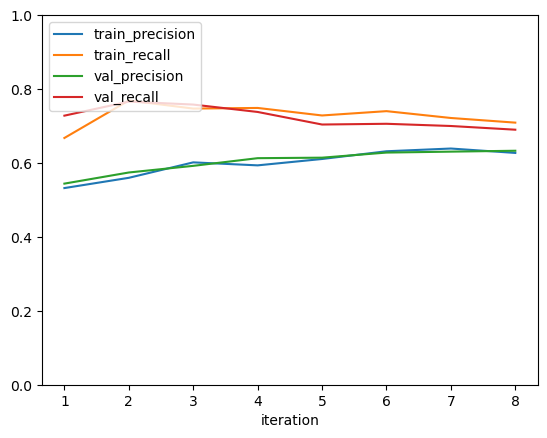

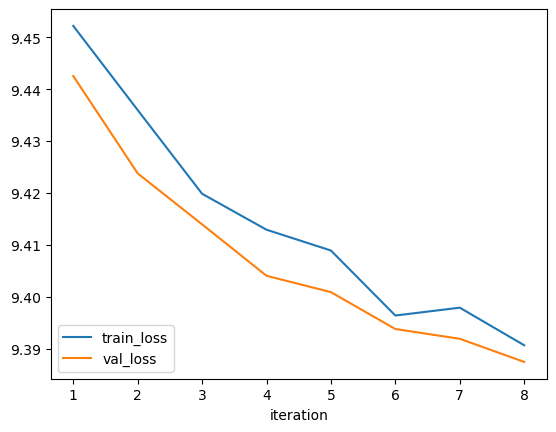

In [194]:
plot_graph(train_precision, train_recall, train_loss, val_precision, val_recall, val_loss)

In [188]:
# TODO:
# add regularization, tune hyper parameters